In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
torch.manual_seed(0)
torch.set_default_dtype(torch.double)
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.double)


In [2]:
#구글 드라이브와 연결
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#데이터 불러오기 : 구글드라이브에있는 경로로 데이터 불러옴
import pandas as pd
"""
X_trian : 훈련데이터
y_train : 훈련데이터 라벨
X_val : 검증데이터
y_val : 검증데이터 라벨
X_test : 테스트데이터
y_test : 테스트데이터 라벨

all_ : 모든 데이터
all_label: 모든 데이터 라벨
"""

X_train = pd.read_csv('/content/drive/MyDrive/projectdata/X_train.csv')
X_val = pd.read_csv('/content/drive/MyDrive/projectdata/validation.csv')
X_test = pd.read_csv('/content/drive/MyDrive/projectdata/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/projectdata/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/projectdata/y_test.csv')
y_test = y_test.drop([y_test.columns[0]],axis=1)
y_train = y_train.drop([y_train.columns[0]],axis=1)
X_train=X_train.drop(X_train.columns[0],axis=1)
y_val = X_val['class'].to_frame().rename(columns={'class':'Class'})
X_val=X_val.drop(['class'],axis=1)
X_val= X_val.drop([X_val.columns[0]],axis=1)
X_test=X_test.drop([X_test.columns[0]],axis=1)
all_ = pd.concat([X_train,X_val,X_test])
all_label=pd.concat([y_train,y_val,y_test])

In [4]:
#Time, Amount feature 스케일링
#RobustScaler() 이용

RS=RobustScaler()
all_['Time'] = RS.fit_transform(all_['Time'].values.reshape(-1,1))
all_['Amount'] = RS.fit_transform(all_['Amount'].values.reshape(-1,1))
i = 0
for temp in [X_train,X_val,X_test]:
  temp['Time']= all_.iloc[i:i+temp.shape[0]]['Time']
  temp['Amount'] = all_.iloc[i:i+temp.shape[0]]['Amount']
  i += temp.shape[0]
  print(i)


159491
216453
284807


outlier가 있으면 학습에 악영향. 스케일링이 필요. V feature들은 스케일링이 되어있지만 Time Amount는 안돼있음 \
RoubstaScaler : outlier에 많이 민감하지 않게 스케일링해줌 
https://mkjjo.github.io/python/2019/01/10/scaler.html

In [5]:
#깔끔하게 함수로 변경하는게 좋을듯?
#print 좀더 이쁜 결과 출력하도록 변경.
"""
이상치 제거: 
상관관계 분석결과 V14, V17이 높으면 class 는 0 에가까움.(낮으면 1에 가까움)
class 0, class 1에서 V14, V17이 outlier로 판단되는 데이터를 없앰

IQR 방법 이용 : 전체 데이터를 기준으로 X_train, X_val에서의 outlier 제거
"""

#상관관계분석 : 가장 낮은(크기가 큰) 두 feature 구하기(V14, V17)
concat=pd.concat([all_,all_label],axis=1)
corr_column= concat.corr()['Class'].sort_values()[:2].index.to_numpy().tolist()
normal_df = concat[concat['Class'] == 0]

for col in corr_column:
    print("remove outlier")
    cut_train = X_train[y_train['Class']==0]
    cut_val = X_val[y_val['Class']==0]

    normal = normal_df[col]
    quantile_25 = np.percentile(normal.values, 25)
    quantile_75 = np.percentile(normal.values, 75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * 1.5
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    #X_trian, X_val에서 outlier 데이터 제거
    outlier_index_train = cut_train[(cut_train[col] < lowest_val) | (cut_train[col] > highest_val)].index
    X_train =X_train.drop(index = outlier_index_train.to_list())
    y_train=y_train.drop(index = outlier_index_train.to_list())
    outlier_index_val = cut_val[(cut_val[col] < lowest_val) | (cut_val[col] > highest_val)].index
    X_val = X_val.drop(index = outlier_index_val.to_list())
    y_val = y_val.drop(index = outlier_index_val.to_list())

    #제거한 outlier 데이터 인덱스 출력
    print("outlier_train",outlier_index_train)
    print("outlier_val",outlier_index_val)

remove outlier
outlier_train Int64Index([    23,    161,    191,    297,    351,    355,    374,    505,
               578,    587,
            ...
            159133, 159134, 159182, 159240, 159283, 159305, 159321, 159351,
            159375, 159443],
           dtype='int64', length=3933)
outlier_val Int64Index([   16,    88,   150,   153,   180,   252,   352,   369,   463,
              578,
            ...
            56713, 56727, 56796, 56803, 56828, 56842, 56871, 56879, 56890,
            56951],
           dtype='int64', length=1410)
remove outlier
outlier_train Int64Index([    18,     25,     51,     72,     80,    110,    238,    250,
               278,    316,
            ...
            159090, 159109, 159124, 159149, 159171, 159269, 159310, 159438,
            159441, 159466],
           dtype='int64', length=5388)
outlier_val Int64Index([   14,    15,   202,   226,   273,   290,   296,   309,   346,
              425,
            ...
            56606, 56664, 56666, 566

In [6]:
normal_df = concat[concat['Class'] == 1]

for col in corr_column:
    print("remove outlier")
    cut_train = X_train[y_train['Class']==1]
    cut_val = X_val[y_val['Class']==1]

    normal = normal_df[col]
    quantile_25 = np.percentile(normal.values, 25)
    quantile_75 = np.percentile(normal.values, 75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * 1.5
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index_train = cut_train[(cut_train[col] < lowest_val) | (cut_train[col] > highest_val)].index

    X_train =X_train.drop(index = outlier_index_train.to_list())
    y_train=y_train.drop(index = outlier_index_train.to_list())

    outlier_index_val = cut_val[(cut_val[col] < lowest_val) | (cut_val[col] > highest_val)].index
    X_val = X_val.drop(index = outlier_index_val.to_list())
    y_val = y_val.drop(index = outlier_index_val.to_list())
    print("outlier_train",outlier_index_train)
    print("outlier_val",outlier_index_val)

remove outlier
outlier_train Int64Index([], dtype='int64')
outlier_val Int64Index([], dtype='int64')
remove outlier
outlier_train Int64Index([107053, 129525], dtype='int64')
outlier_val Int64Index([20031, 25903], dtype='int64')


IQR 방법 : https://www.kaggle.com/dogdriip/iqr-outlier-smote-oversampling



In [7]:
"""
cross validation 적용 :
X_train, X_val을 붙여 X_cross를 만들고, X_cross를 5등분(5-folds).
번갈아가며 4-folds 는 훈련데이터 , 1-fold 는 검증데이터로 이용.
"""
X_cross = pd.concat([X_train, X_val])
y_cross=pd.concat([y_train, y_val])

from sklearn.model_selection import StratifiedKFold
n_splits = 5
stk = StratifiedKFold(n_splits=n_splits,shuffle=True)

cross-validation:
https://velog.io/@skyepodium/K-Fold-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D \

stratifledKfold : 데이터를 folds로 나눌때 라벨값의 비율도 고려. credit fraud 데이터와 같이 불균형한 데이터에서 적절하게 fold를 형성함

In [8]:
#from imblearn import SMOTE
#sm = SMOTE(sampling_strategy=0.1)
#Xsm_train, ysm_train =sm.fit_sample(X_train, y_train)

oversampling : class 1 인 데이터가 너무 작으니, 가지고 있는 데이터를 가지고 다양한 1인 데이터 형성하는 기법.(그중 SMOTE 이용) \
적용결과 : recall은 굉장히 높았지만 precision이 0에 가까움. class 0인데이터를 1로 분류한게 많다는 의미. \
분석) 원래 가지고있던 두 클래스의 데이터가 서로 가까운게 많아, SMOTE로 1 데이터를 많이 만들었을때 오히려 신경망이 경계를 잘 못잡음. \
https://log-laboratory.tistory.com/343
credit fraud (1),(2),(3) 대강 읽으면 전체적인 흐름 파악하는데 도움 많이될거같습니다.

In [9]:
class Residual(nn.Module):
  def __init__(self, m, layers=2):
    super(Residual,self).__init__()
    seq = []
    for _ in range(layers):
      seq+=[nn.Linear(m,m),nn.BatchNorm1d(m),nn.LeakyReLU(0.2),nn.Dropout(0.1)]
    self.main = nn.Sequential(*seq)
  def forward(self, in_):
    output = self.main(in_) + in_
    return output

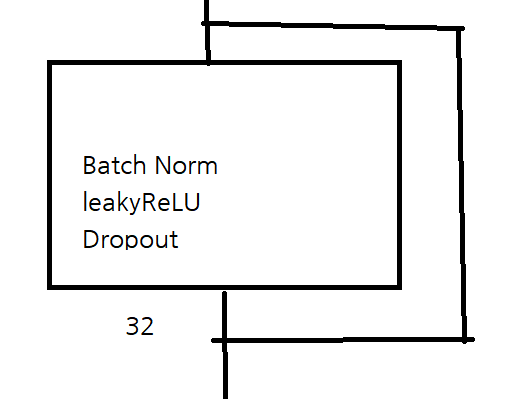

신경망 연산후 위 그림에 보이는 순서로 각각 연산 수행 \
BatchNorm : 신경망 연산의 출력을 normalization 해줌. gradient값이 너무 커지거나 너무 낮아지지 않도록 함. \
leakyReLU : 활성화함수
Dropout : 다음 층으로 전달되는 출력의 수를 줄임. 모델에선 랜덤하게 10% 줄이고 전달. \
알고리즘 3~4줄정도 간단하게 찾아서 ppt에 넣으면 좋을거같습니다.

In [10]:
class DNN(nn.Module):
    def __init__(self, i, o, m, layers):
        super(DNN, self).__init__()
        seq = []
        seq += [nn.Linear(i,m),nn.BatchNorm1d(m),nn.LeakyReLU(0.2)]
        for _ in range(layers):
            seq+=[Residual(m,layers=1)]
        seq+=[nn.Linear(m,o)]
        self.main=nn.Sequential(*seq)
    def forward(self, in_):
        output = self.main(in_)
        return output
        

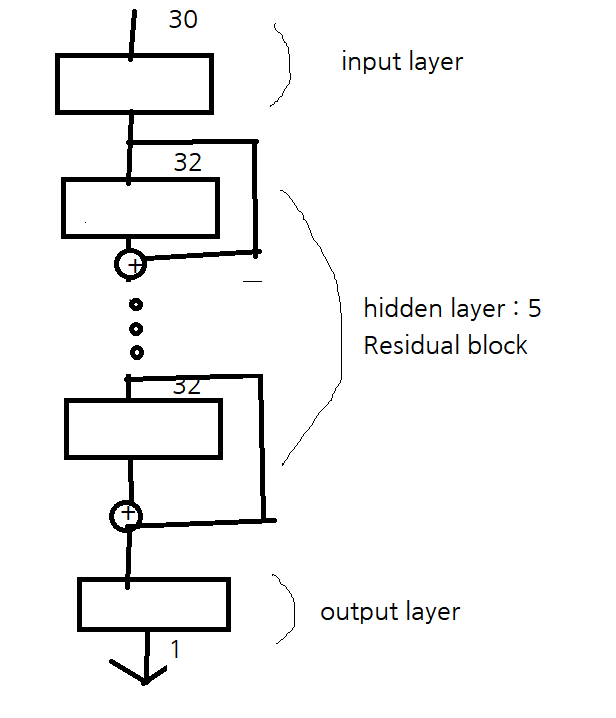

위 그림과 같은 구조 \
resnet : 그림처럼 layer의 입력을 출력과 더해줌. gradient 값이 잘 전달되게 하는게 목표. 주로 깊은 신경망에 쓰임 \
출력으로 나온 1개 feature값은 학습과정에서 sigmoid 를 거쳐 역전파

In [11]:
batch_size = 64
epoch = 5 
iteration = 30000

"""gpu에 torch를 객체를 집어넣는 함수"""
def cudify(v):
    if torch.cuda.is_available() :
        return v.cuda()
    else:
        return v

In [21]:
class early_stop:
  def __init__(self, path, patient = 7,delta=0):
    self.patient = patient
    self.best_score = None # val_loss가 최고로 낮을때 점수
    self.counter = 0 # val_loss가 연속으로 상향하지 않은 횟수
    self.early_stop = False
    self.path = path # 최고 성능 모델을 저장하는 경로.
    self.delta = delta
  def __call__(self, val_loss, model): # validation 과정마다 이전값에서 떨어졌는지 증가했는지 비교.
        score = val_loss
        if self.best_score is None: 
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score+self.delta:
            #현재 val_loss가 best_score 보다 나쁘다면(더 큰경우) counter 하나 증가
            self.counter += 1
            if self.counter % 25 == 0:
              print(f'EarlyStopping counter: {self.counter} out of {self.patient}')
            if self.counter >= self.patient:
              #counter값이 patient에 도달하면 학습을 종료.
              self.early_stop = True
        else:
            #val_loss값이 best_score보다 작은경우
            #현재 모델이 최고성능이라는 의미. self.path의 경로에 저장한다.
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
  def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델 저장.'''
        torch.save(model.state_dict(), self.path)
  def initialize(self):
    self.counter = 0
    self.early_stop = False


early stop : 검증데이터를 모델에 집어넣은 후 나오는 loss 값을 가지고 더 떨어졌는지 안떨어졌는지 비교. loss가 안떨어지는 상황이 patient(50번) 정도 계속 되면 학습종료. \
검증데이터(validation)을 어떻게 활용하는지 보고오시면 코드 읽는데 도움 많이 될거 같습니다
https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0


In [22]:
"""학습 코드"""


model_path = '/content/drive/MyDrive/Colab Notebooks/modelsave/checkpoint.pt'

test_ = torch.from_numpy(X_test.to_numpy())
result = torch.zeros([test_.shape[0],1]) #각 모델에 대한 모델의 예측값 저장

#visualizatin에 필요한 변수
all_train_loss=[]
all_val_loss=[]

for i , (train_id, val_id) in enumerate(stk.split(X_cross,y_cross)):
  """StratifiedKFold를 이용한 cross validation"""
  early_stopper= early_stop(path=model_path,patient=50) 
  print("cross validation batch",i)
  #model 생성
  model=DNN(i=all_.shape[1],o=1,m=32,layers=5)
  if torch.cuda.is_available():
      model.cuda()
  #criterion = nn.BCELoss() #loss함수
  model_optimizer = optim.Adam(model.parameters(),lr=1e-4,weight_decay=0.9)
  
  #train dataset 만들기
  train_ = X_cross.iloc[train_id].to_numpy()
  label_ = (y_cross.iloc[train_id].to_numpy()).astype(np.float64)
  
  #val만들기: 매 epoch 마다 val_loss 계산
  #모든 검증데이터를 gpu에 집어넣음
  val_ = X_cross.iloc[val_id].to_numpy()
  val_ = cudify(torch.from_numpy(val_))
  val_label = (y_cross.iloc[val_id].to_numpy()).astype(np.float64)
  val_label=cudify(torch.from_numpy(val_label))
  
  #visualization 할때 필요한 변수
  train_loss_list=[]
  val_loss_list=[]

  for j in range(epoch):
    """실제 학습
    매 epoch 마다 lr을 절반으로 줄임
    fold dataset에 대해 epoch만큼 학습이 끝나면 
    테스트 데이터셋에 대한 예측확률값 result에 저장.
    """
    print("epoch: ",j)
    early_stopper.initialize()
    for k in range(iteration):
        model.train() #model을 학습모드로 변경.
        model_optimizer.zero_grad()

        #batch_size(64) 크기의 데이터를 랜덤하게 불러옴
        batch_index=np.random.choice(train_.shape[0],size=batch_size,replace=False)
        batch_data = train_[batch_index]

        #gpu에 집어넣음
        target=cudify(torch.from_numpy(batch_data))
        batch_label = cudify(torch.from_numpy(label_[batch_index]))

        #loss 계산
        loss = F.binary_cross_entropy_with_logits(model(target), batch_label)
        loss.backward() #역전파
        model_optimizer.step()

        #model.eval() : batchnorm 계층때문에 eval모드로 검증데이터 loss 확인 불가능
        with torch.no_grad():#검증 데이터 성능 확인
          val_loss = F.binary_cross_entropy_with_logits(model(val_),val_label)
          if k % 100 == 0:
            print('index : ',k, "train_loss: ",loss.item(), "val_loss: ",val_loss.item())

          #val_loss를 가지고 현재 stop 해야하는지 아닌지 결정
          early_stopper(val_loss,model)
          if early_stopper.early_stop:
            # patient(50)번 성능 향상이 없다면 학습 종료
            print(k,"early stop")
            break
        train_loss_list.append(loss.item())
        val_loss_list.append(val_loss.item())
    model_optimizer.param_groups[0]['lr'] /=2 #lr을 절반으로 줄임. weight decay
    model.load_state_dict(torch.load(model_path)) #early stop 과정에서 저장된 가장 좋은 모델을 가져옴,
  all_train_loss.append(train_loss_list)
  all_val_loss.append(val_loss_list)
  #test 데이터에 대한 모델 성능 평가.
  model.eval()
  model.cpu()
  result += F.sigmoid(model(test_))

  

cross validation batch 0
epoch:  0
index :  0 train_loss:  0.9190492771893713 val_loss:  0.8490241036172571
index :  100 train_loss:  0.602118636368148 val_loss:  0.5779256956336254
index :  200 train_loss:  0.40359736466578655 val_loss:  0.412860591448591
index :  300 train_loss:  0.35480634859972227 val_loss:  0.3136358745716529
index :  400 train_loss:  0.22063658880415743 val_loss:  0.2521535725100145
index :  500 train_loss:  0.16800873176998912 val_loss:  0.20905158213374106
index :  600 train_loss:  0.1468080340050972 val_loss:  0.18249743721468534
index :  700 train_loss:  0.1371588870165017 val_loss:  0.16030256800284823
index :  800 train_loss:  0.10878452199727295 val_loss:  0.13986998621691604
index :  900 train_loss:  0.10677933625687089 val_loss:  0.12418228484146152
index :  1000 train_loss:  0.09384200333750856 val_loss:  0.10943001625353281
index :  1100 train_loss:  0.08535702722338226 val_loss:  0.1015220843137396
index :  1200 train_loss:  0.07604743417639759 val_lo

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


cross validation batch 1
epoch:  0
index :  0 train_loss:  2.24009678247958 val_loss:  2.100612540223869
index :  100 train_loss:  1.6439953933962668 val_loss:  1.5798854705329648
index :  200 train_loss:  1.226083243796716 val_loss:  1.1527730408538803
index :  300 train_loss:  0.9195473229910425 val_loss:  0.8337298606602137
index :  400 train_loss:  0.5920990759253488 val_loss:  0.6152551812341236
index :  500 train_loss:  0.4752040380173529 val_loss:  0.47095416966328213
index :  600 train_loss:  0.38947653227115775 val_loss:  0.3771119152481559
index :  700 train_loss:  0.3007345298073715 val_loss:  0.3110730181479488
index :  800 train_loss:  0.2393183264745708 val_loss:  0.26271315829799813
index :  900 train_loss:  0.1946390122167026 val_loss:  0.22676798937337345
index :  1000 train_loss:  0.19407252291492388 val_loss:  0.19910007722763018
index :  1100 train_loss:  0.19613068163103026 val_loss:  0.17617158697008536
index :  1200 train_loss:  0.13842710239098194 val_loss:  0.1

실제 학습과정 : \
train_, label_ 로 부터 64(batch_size)크기의 데이터를 랜덤으로 가져오고 이걸 gpu에 집어 넣음 \
loss 계산 (F.binary_cross.. : cross entropy loss 함수) 후 역전파 ( loss.backward) 마지막으로 모델의 가중치 수정(model_optimizer.step) \
with torch.no_grad : 이 부분이 검증데이터 loss 확인하는 부분. 검증데이터 loss가 50번(patient) 정도 성능 향상이 없다면 학습 종료.

early stop 으로 인해 학습이 종료되면, optimizer의 learning rate를 절반으로 줄여서 다시 학습에 들어간다. 이런 과정이 총 epoch = 5번 만큼 반복됨

learning rate 줄이는걸 epoch 만큼 반복을 다 했다면, 지금 현재 모델을 가지고 test dataset에 대한 성능을 출력한다. 이를 result에 더하는 방식으로 저장(+=) \
다음 dataset에 대해 전체과정을 또 반복한다.(학습하고, early stop으로 종료하고, learning rate 줄이고, 학습하고,,,) \
dataset은 앞에서 cross validation으로 총 5번 만들 수 있음. 

In [23]:
from sklearn.metrics import recall_score, precision_score, f1_score
#모델들이 출력한 평균 확률값이 0.5 이상이면 class 1, 아니면 0으로 분류
result_list = np.where(result/n_splits > 0.5, 1, 0)

#실제 test dataset의 class
test_label=y_test.to_numpy()

TN 68241
FP 12
FN 21
TP 80
recall score :  0.7920792079207921
precision score :  0.8695652173913043
f1 score :  0.8290155440414507


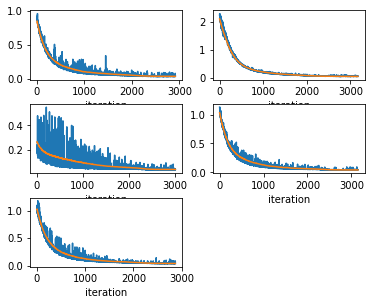

In [25]:
from sklearn.metrics import confusion_matrix
import math
"""
TN,FP,FN,TP 분석
"""

matrix = confusion_matrix(test_label,result_list)
print("TN", matrix[0][0])
print("FP", matrix[0][1])
print("FN", matrix[1][0])
print("TP", matrix[1][1])
#matrix[i][j] : true class i, predict class j
print("recall score : ",recall_score(test_label,result_list))
print("precision score : ",precision_score(test_label,result_list))
print("f1 score : ",f1_score(test_label,result_list))


"""
train loss 
val loss 시각화
"""
row = math.ceil(n_splits/2)
for i in range(n_splits):
  plt.subplot(row,2,i+1)
  plt.xlabel('iteration')
  plt.plot(all_train_loss[i])
  plt.plot(all_val_loss[i])
  plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)


TP, TN, FP, FN 에 대해 찾아보시면 좋을거같습니다.

코드 구현 남은 작업: \
1)코드 .py형태로 바꾸기, 이쁘게바꾸기 \
2) 저장경로 확인 \
3) local에서 굴러가는지 확인 \
4) 각 모델 저장

# 새 섹션